# Telco Customer Churn

In [1]:
import numpy as np
import pandas as pd
import keras as ks
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sn
pd.set_option('display.max_columns', 2000)

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## User Defined Functions

Heatmaps of confusion matrix

In [2]:
def fn_plot_confusionMatrix(cm,titles):
    fig, ax = plt.subplots(nrows=2, ncols = 2, figsize=(10,8))
    k = 0
    for i in ax:
        for j in i:
            sn.heatmap(cm[k], annot=True, 
                   fmt='d', 
                   xticklabels=np.sort(y_train.Churn.astype("int").unique()), 
                   yticklabels=np.sort(y_train.Churn.astype("int").unique()), 
                   ax=j)
            j.set_title(titles[k])
            j.set_xlabel("Prediction")
            j.set_ylabel("Actual")
            k = k + 1 
    return plt

Metrics of a classification problem

In [3]:
def fn_metrics(cm_):
    met_=[]
    for i in cm_:
        true_pos = i[1][1]
        true_neg = i[0][0]
        false_pos = i[0][1]
        false_neg = i[1][0]
        accuracy = (true_pos+true_neg)/(true_pos+true_neg+false_pos+false_neg)
        precision = true_pos /(true_pos+false_pos)
        recall = true_pos/(true_pos+false_neg)
        f1_score = 2*precision*recall/(precision+recall)
        met_.append(pd.DataFrame(data=[accuracy,precision,recall,f1_score],index=["accuracy","precision","recall","f1_score"]))
    return met_

## Importing the file

In [4]:
master_dataset = pd.read_csv("Datasets/Teleco_Cust_Attr.csv",header=0)
master_dataset.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
master_dataset.describe(include = 'all')

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7043,7043,7043.000000,7043,7043,7043.000000,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2,NaN,2,3,3,3,3,3,3,3,3,3,2,4,NaN,6531,2
top,3580-HYCSP,Male,NaN,No,No,NaN,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,NaN,20.2,No
freq,1,3555,NaN,3641,4933,NaN,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,NaN,11,5174
mean,NaN,NaN,0.162147,NaN,NaN,32.371149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN,24.559481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN,29.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN,55.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN,NaN


In [6]:
master_dataset.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [7]:
master_dataset.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

## Data Preprocessing and EDA

Dropping customerID and TotalCharges

customerID is an unique identifier which doesn't help in building predictive model

Converting SeniorCitizen to catgeory

In [8]:
master_dataset.drop("customerID", axis = 1, inplace=True)
master_dataset.drop("TotalCharges", axis = 1,  inplace=True)
master_dataset["SeniorCitizen"] = master_dataset["SeniorCitizen"].astype("category")

In [9]:
bins = np.linspace(0, 100, 20)
master_dataset["binned_tenure"] = np.digitize(master_dataset["tenure"], bins)
master_dataset["binned_tenure"] = master_dataset["binned_tenure"].astype("category")

bins = np.linspace(0, 200, 20)
master_dataset["binned_MonthlyCharges"] = np.digitize(master_dataset["MonthlyCharges"], bins)
master_dataset["binned_MonthlyCharges"] = master_dataset["binned_MonthlyCharges"].astype("category")

master_dataset.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn,binned_tenure,binned_MonthlyCharges
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,No,1,3
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,No,7,6
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,Yes,1,6
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,No,9,5
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,Yes,1,7


#### Relation of Churn with binned_tenure 

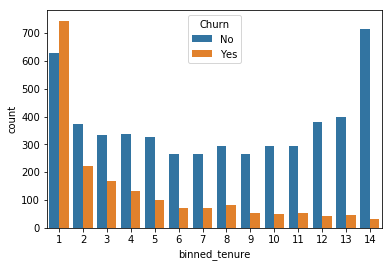

In [10]:
sn.countplot(x="binned_tenure", hue="Churn", data=master_dataset)

Customers falling into the first binned tenure have churned alot and as tenure increases, churn rate has decreased.

Logically dividing data into 2 sets - Binned Tenure 1, and all others. 

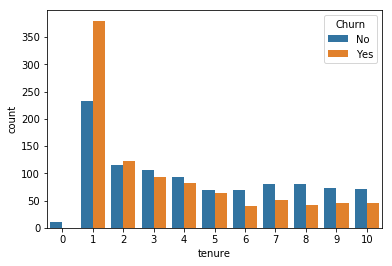

In [11]:
x = master_dataset.loc[master_dataset.loc[:,"binned_tenure"].astype("int64") <3].copy()
x.describe(include="all")
x["tenure"] = x["tenure"].astype("category")
sn.countplot(x="tenure", hue="Churn", data=x)

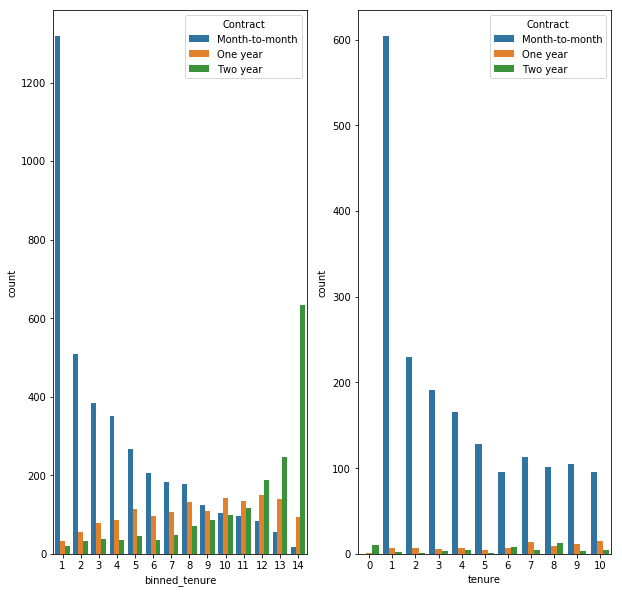

In [12]:
fig, ax = plt.subplots(nrows=1, ncols = 2, figsize=(10,10))
sn.countplot(x="binned_tenure", hue="Contract", data=master_dataset, ax=ax[0])
sn.countplot(x="tenure", hue="Contract", data=x, ax=ax[1])

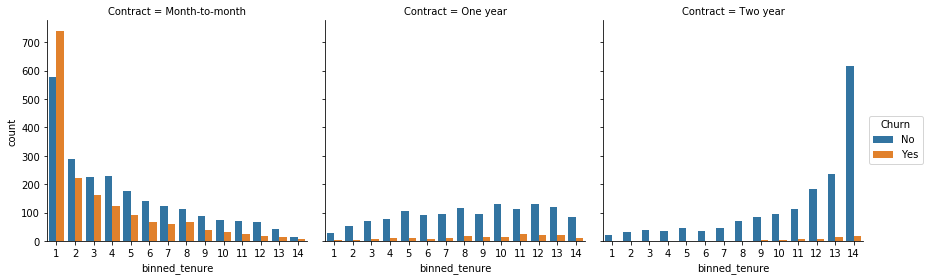

In [13]:
sn.factorplot(x="binned_tenure", hue="Churn",col="Contract", data=master_dataset, kind="count")

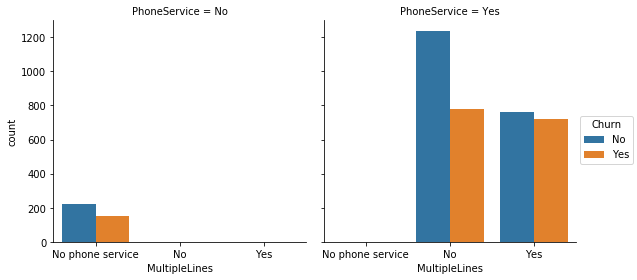

In [14]:
x = master_dataset.loc[master_dataset.loc[:,"Contract"]=="Month-to-month"].copy()
sn.factorplot(col="PhoneService", hue="Churn",x="MultipleLines", data=x, kind="count")

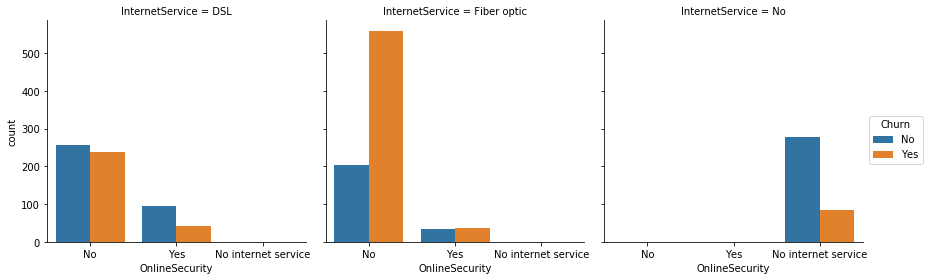

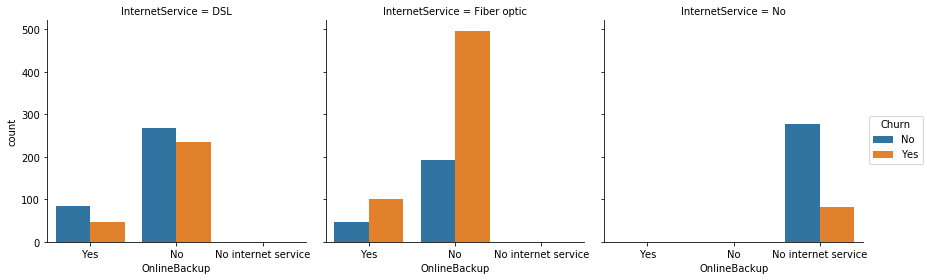

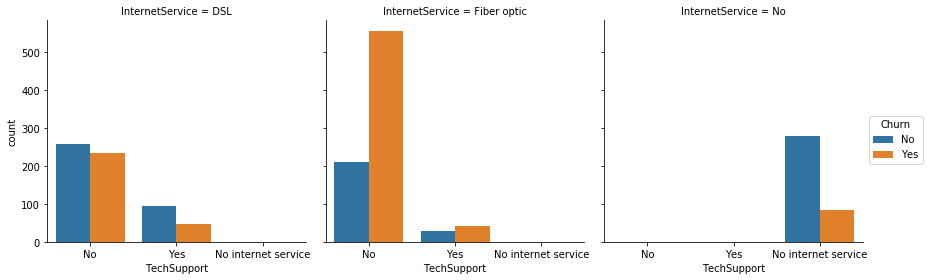

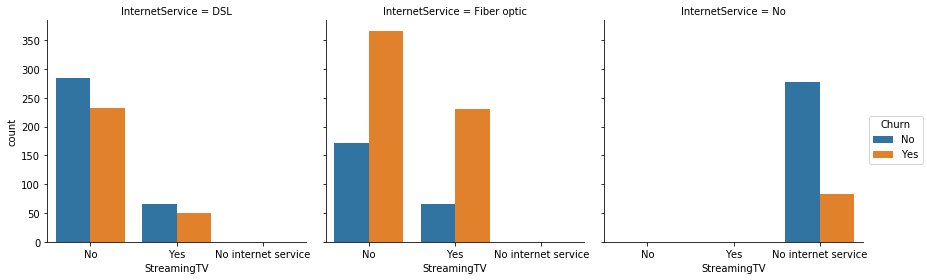

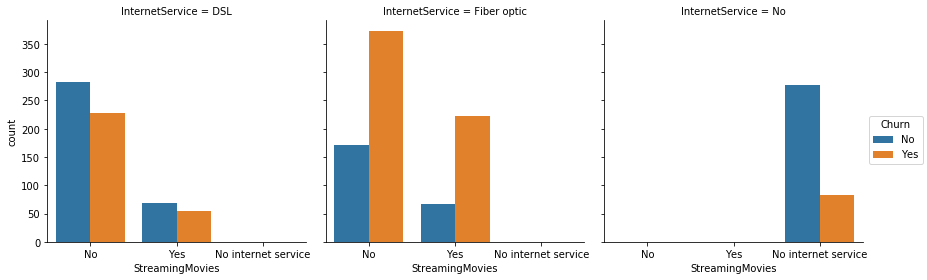

In [50]:
services = ["OnlineSecurity","OnlineBackup","TechSupport","StreamingTV","StreamingMovies"]
master_dataset['services_'] = master_dataset[services].apply(lambda x: ' '.join(x), axis=1)
x = master_dataset.loc[(master_dataset.loc[:,"Contract"]=="Month-to-month") 
                       & (master_dataset.loc[:,"binned_tenure"].astype("int64") <3)  ].copy()

for services_ in services:
    sn.factorplot(col="InternetService", x=services_ , hue="Churn", data=x, kind="count")

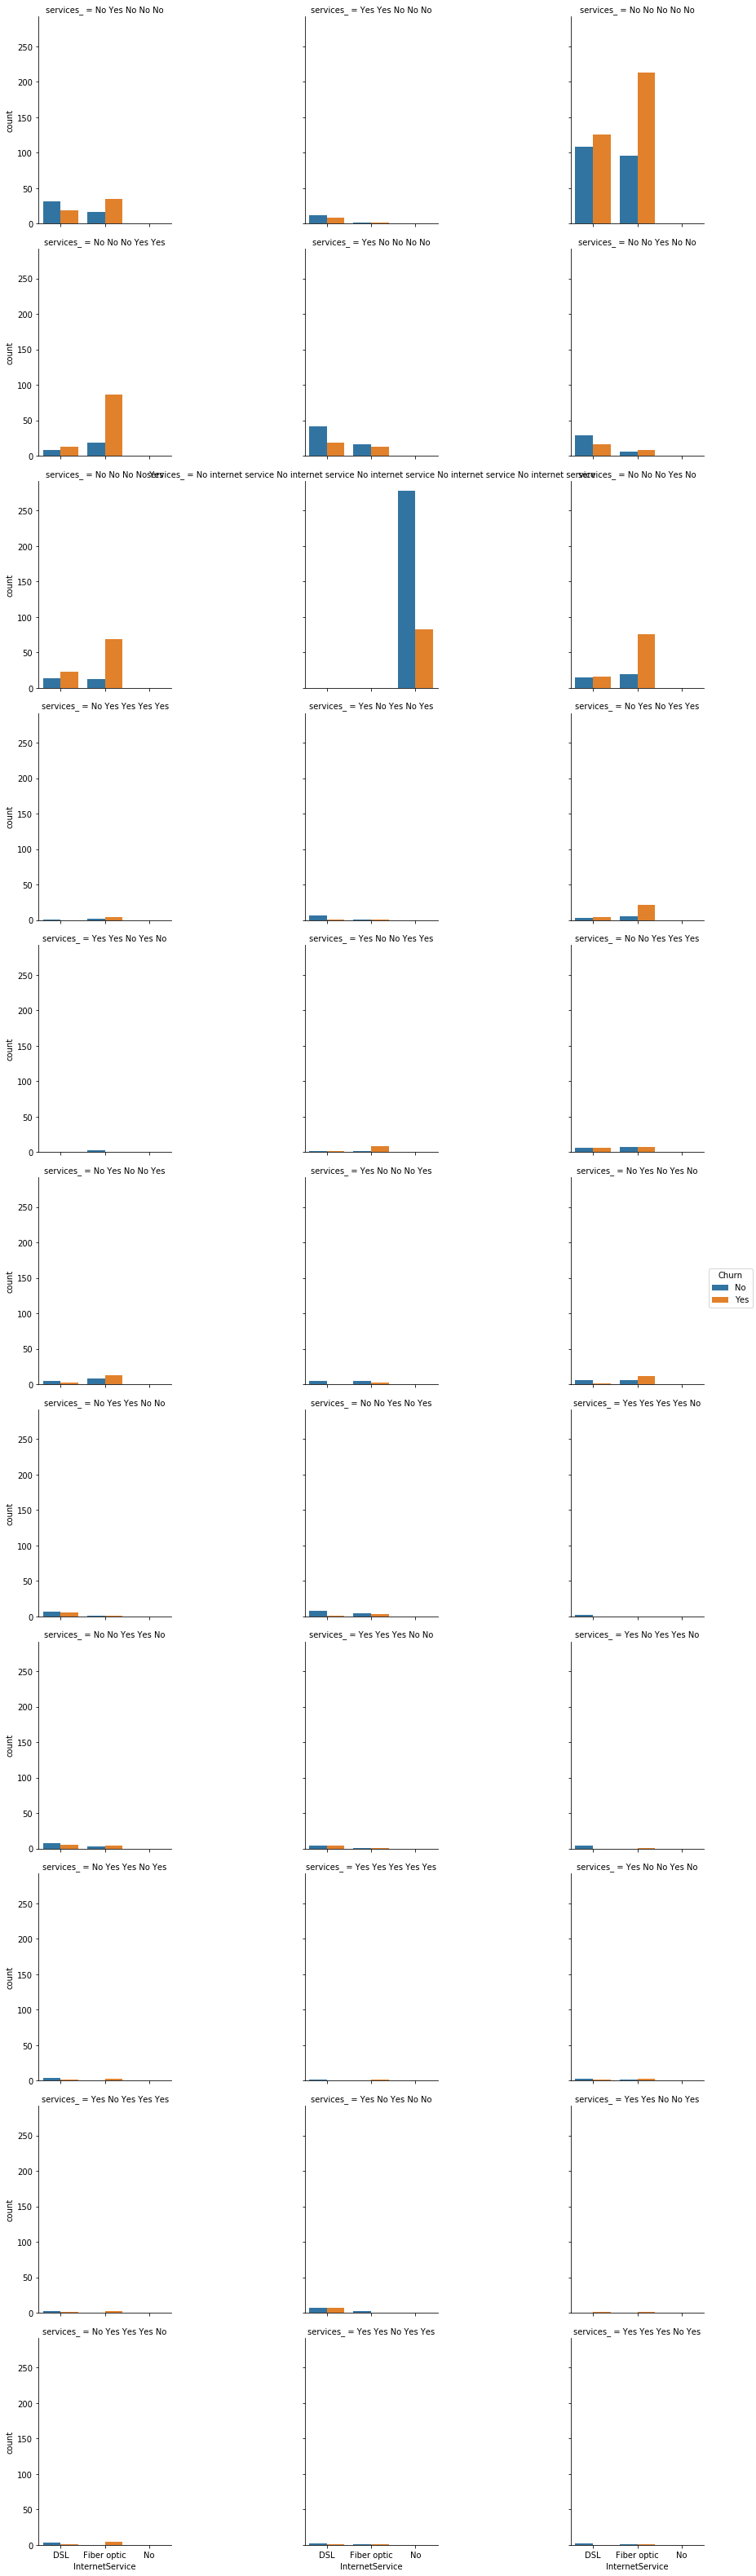

In [63]:
sn.factorplot(x="InternetService", col="services_" , hue="Churn", data=x, kind="count", col_wrap=3)

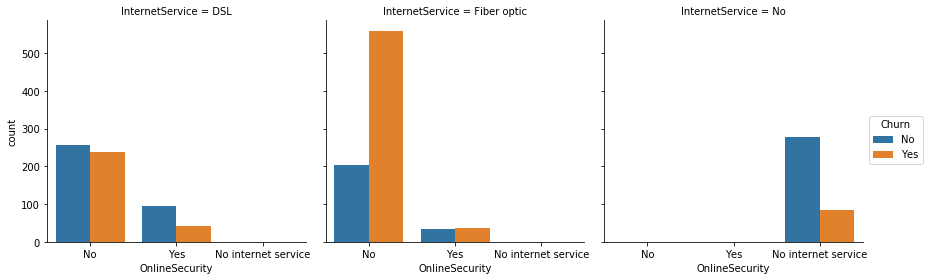

In [31]:
x = master_dataset.loc[(master_dataset.loc[:,"Contract"]=="Month-to-month") 
                       & (master_dataset.loc[:,"binned_tenure"].astype("int64") <3)  ].copy()
sn.factorplot(col="InternetService", hue="Churn",x="OnlineSecurity", data=x, kind="count")

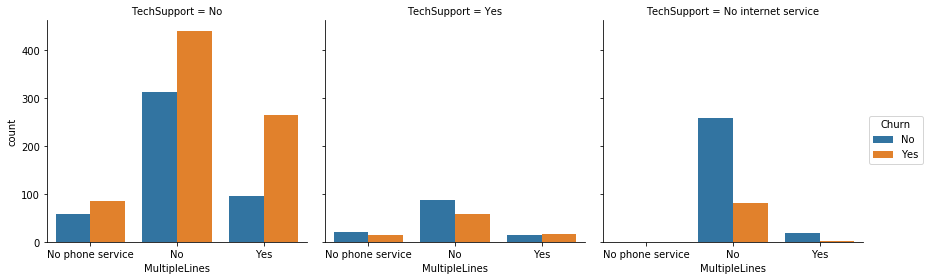

In [29]:
sn.factorplot(col="TechSupport", hue="Churn",x="MultipleLines", data=x, kind="count")